In [1]:
import sys
sys.path.append('../')
from source.interference_reject import InterferenceReject
import numpy as np
from source.reader import read_raw
from source.gridding import NFFT
import matplotlib.pyplot as plt
%matplotlib inline

## Data import

In [12]:
file_name = "../data/fse_ecg_trim.h5"
data, index, metadata = read_raw(file_name)
# Channel definitions
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
select_channels_signal = np.arange(num_channels_signal)
select_channels_noise = np.arange(num_channels_signal, num_channels_all)
select_channels_no_esensor = select_channels_noise[1:]
# Encoding
matrix_size = metadata['sequence']['encoding']['matrix_size']
k_x = index['scan']['encoding_1']
k_y = index['scan']['encoding_2']
k_2d = np.pi * np.vstack((k_x, k_y)).T

## Interference rejection

In [13]:
data_scan = data['scan']

# Dynamic method: compute coefficients on the fly, in data bins
lines_per_bin = 100
num_lines_acq = data_scan.shape[0]
num_bins = int(np.ceil(num_lines_acq / lines_per_bin))
lines_per_bin = int(np.round(num_lines_acq / num_bins))
bin_index = lines_per_bin * np.arange(num_bins)
bin_index = np.concatenate((bin_index, [num_lines_acq - 1]))

# Use all reference channels
rej_weighted = InterferenceReject(
    use_weights=True,
    channels_signal=select_channels_signal,
    channels_noise=select_channels_noise,
    num_freq_bins=matrix_size[0],
)
data_cor_all = np.zeros([data_scan.shape[0], num_channels_signal, data_scan.shape[2]], dtype=np.complex64)
for _b in range(num_bins):
    sel_bin = slice(bin_index[_b], bin_index[_b + 1])
    data_cor_all[sel_bin, :, :] = rej_weighted.apply(scan_raw=data_scan[sel_bin, :, :], k_coords=k_2d[sel_bin, :])

# Use all reference channels except e-sensor
rej_weighted = InterferenceReject(
    use_weights=True,
    channels_signal=select_channels_signal,
    channels_noise=select_channels_no_esensor,
    num_freq_bins=matrix_size[0],
)
data_cor_no_esensor = np.zeros([data_scan.shape[0], num_channels_signal, data_scan.shape[2]], dtype=np.complex64)
for _b in range(num_bins):
    sel_bin = slice(bin_index[_b], bin_index[_b + 1])
    data_cor_no_esensor[sel_bin, :, :] = rej_weighted.apply(scan_raw=data_scan[sel_bin, :, :], k_coords=k_2d[sel_bin, :])


## Plot k-space

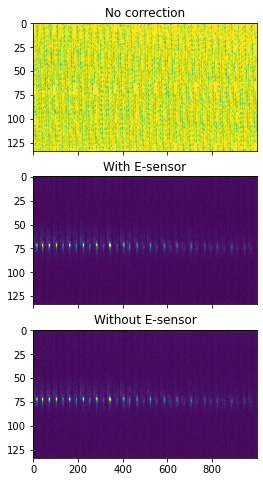

In [14]:
ch = 0
n_lines = 1000
max_k = np.max(np.abs(data_cor_all))
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(4,8))
ax[0].set_title("No correction")
ax[0].imshow(np.squeeze(np.abs(data['scan'][:n_lines, ch, :])).T, aspect='auto', vmin=0, vmax=max_k/5)
ax[1].set_title("With E-sensor")
ax[1].imshow(np.squeeze(np.abs(data_cor_all[:n_lines, ch, :])).T, aspect='auto', vmin=0, vmax=max_k/5)
ax[2].set_title("Without E-sensor")
ax[2].imshow(np.squeeze(np.abs(data_cor_no_esensor[:n_lines, ch, :])).T, aspect='auto', vmin=0, vmax=max_k/5)
# fig.savefig("methods_rejection_kspace.tif", dpi=600, format="tiff")

## Fourier reconstruction

In [15]:
# Apply readout FT
spec_scan = np.fft.fftshift(np.fft.fft(data['scan'], axis=-1), axes=-1)
spec_cor_all = np.fft.fftshift(np.fft.fft(data_cor_all, axis=-1), axes=-1)
spec_cor_no_esensor = np.fft.fftshift(np.fft.fft(data_cor_no_esensor, axis=-1), axes=-1)
# Apply non-uniform FT
encode_op = NFFT(k_coords=k_2d, image_size=matrix_size[1:], n_channels=num_channels_signal)
dims_4d = np.concatenate((matrix_size, [num_channels_signal]))
img_nocor = np.zeros(dims_4d, dtype=np.complex64)
img_cor_all = np.zeros(dims_4d, dtype=np.complex64)
img_cor_no_esensor = np.zeros(dims_4d, dtype=np.complex64)
for _f in range(spec_scan.shape[-1]):
    img_nocor[_f, :, :, :] = encode_op.adjoint(spec_scan[:, :8, _f])
    img_cor_all[_f, :, :, :] = encode_op.adjoint(spec_cor_all[:, :, _f])
    img_cor_no_esensor[_f, :, :, :] = encode_op.adjoint(spec_cor_no_esensor[:, :, _f])

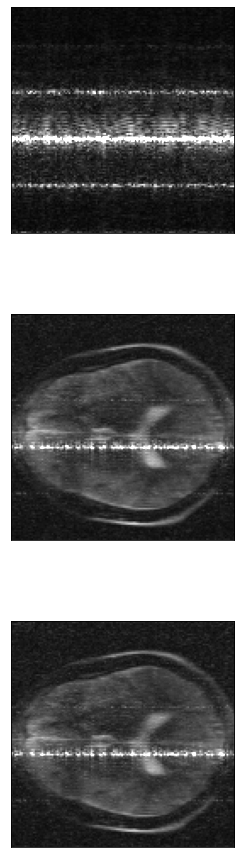

In [16]:
# Plot data
sos_nocor = np.sqrt(np.sum(np.abs(img_nocor) ** 2, axis=-1))
# sos_nocor = np.abs(img_nocor[..., 7])
sos_cor_all = np.sqrt(np.sum(np.abs(img_cor_all) ** 2, axis=-1))
sos_cor_no_esensor = np.sqrt(np.sum(np.abs(img_cor_no_esensor) ** 2, axis=-1))

scaling = 5
slc = 17
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(4,16))
ax[0].imshow(np.abs(sos_nocor[:, :, slc]), cmap='gray', vmin=0, vmax=scaling * np.mean(sos_nocor))
ax[1].imshow(np.abs(sos_cor_all[:, :, slc]), cmap='gray', vmin=0, vmax=scaling * np.mean(sos_cor_all))
ax[2].imshow(np.abs(sos_cor_no_esensor[:, :, slc]), cmap='gray', vmin=0, vmax=scaling * np.mean(sos_cor_no_esensor))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
# fig.savefig("methods_rejection_image.tif", dpi=600, format="tiff")